# Project - Fifth Requierement

### Import libraries and packages

In [38]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from copy import deepcopy
from itertools import product

## Environment

In [39]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

In [40]:
import numpy as np
from scipy.stats import norm

class PricingEnvironmentMultiProductPiecewiseMean:
    def __init__(self, cost_vector, mean_valuation_schedule, std_valuations, buyers_per_round, total_rounds):
        """
        mean_valuations_list: list of 3 arrays, one for each interval (e.g. [mean_1, mean_2, mean_3])
        """
        self.cost_vector = np.array(cost_vector)
        self.mean_valuations_list = [np.array(m) for m in mean_valuation_schedule]
        self.std_valuations = np.array(std_valuations)
        self.buyers_per_round = buyers_per_round
        self.total_rounds = total_rounds
        self.current_round = 0

        # Compute the round thresholds
        self.interval_size = total_rounds // 3

    def round(self, p_t_vector):
        # Determine the current interval
        if self.current_round < self.interval_size:
            mean_valuations = self.mean_valuations_list[0]
        elif self.current_round < 2 * self.interval_size:
            mean_valuations = self.mean_valuations_list[1]
        else:
            mean_valuations = self.mean_valuations_list[2]

        # Compute the probability of buying and sample sales
        prob_buy = 1 - norm.cdf(np.array(p_t_vector), loc=mean_valuations, scale=self.std_valuations)
        num_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)

        # Compute reward
        reward = (np.array(p_t_vector) - self.cost_vector) * num_sales
        self.current_round += 1
        return num_sales, reward


In [41]:
# --- Global Settings ---

N = 3                       # Number of products
T = 20000                   # Time horizon
n_trials = 3                # Independent trials

# --- Pricing Grid and Product Info ---

cost_vector = np.array([2.0, 2.5, 3.0])             # Costs per product
initial_values = np.array([5.0, 6.0, 5.5])          # Initial mean valuations
std_valuations = np.array([1.0, 1.2, 0.8])          # Std for each product

min_p = 0.0
max_p = int(np.max(initial_values) * 2)

K = 10
P = np.linspace(min_p, max_p, K)                    # Shared price grid for all products

assert np.all(cost_vector < initial_values), "Each cost must be less than its initial valuation"

# --- Market and Inventory Parameters ---

B = 120000 * N                                      # Total shared inventory

amplitudes = np.array([2.0, 1.5, 1.0])
periods = np.array([1000, 1500, 800])

buyers_per_round = 50                               # Number of buyers per round

# --- Other Parameters ---

zoom_end = 2 * max(periods)     # Show only up to 2x the max period in main plots
zoom_end_mini = 200             # Show only up to 200 rounds in mini plots
zoom_end_5 = 5000               # Start zooming 5k rounds
s = 30                          # random seed

# --- Formatter for Millions in the plots---
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'


mean_valuation_schedule = [
    [5.0, 6.0, 5.5],  # T1
    [6.0, 5.0, 6.5],  # T2
    [5.5, 6.5, 5.0],  # T3
]

env = PricingEnvironmentMultiProductPiecewiseMean(
    cost_vector=cost_vector,
    mean_valuation_schedule=mean_valuation_schedule,
    std_valuations=std_valuations,
    buyers_per_round=buyers_per_round,
    total_rounds=T
)


In [42]:
class SlidingWindowUCB:
    def __init__(self, n_products, price_grid, cost_vector, window_size=100):
        self.n_products = n_products
        self.P = price_grid
        self.K = len(price_grid)
        self.cost_vector = cost_vector
        self.window_size = window_size

        self.rewards = np.zeros((n_products, self.K, 0))  # dynamic along axis 2 (time)

    def select_prices(self):
        p_t = []
        for i in range(self.n_products):
            est_profits = []
            for a in range(self.K):
                rew = self.rewards[i, a, -self.window_size:] if self.rewards.shape[2] > 0 else []
                n = len(rew)
                if n == 0:
                    est = np.inf  # force exploration
                else:
                    mean = np.mean(rew)
                    conf = np.sqrt(2 * np.log(max(1, np.sum(self.rewards[i, :, -self.window_size:].shape[1]))) / n)
                    est = mean + conf
                est_profits.append(est)
            best_idx = np.argmax(est_profits)
            p_t.append(self.P[best_idx])
        return p_t

    def update(self, prices, rewards):
        for i in range(self.n_products):
            price_idx = np.argmin(np.abs(self.P - prices[i]))  # find closest price in grid
            new_r = np.array([rewards[i]])
            if self.rewards.shape[2] == 0:
                self.rewards = np.zeros((self.n_products, self.K, 1))
                self.rewards[i, price_idx, 0] = new_r
            else:
                pad_shape = (self.n_products, self.K, 1)
                self.rewards = np.concatenate([self.rewards, np.zeros(pad_shape)], axis=2)
                self.rewards[i, price_idx, -1] = new_r
                # truncate if exceeding window
                if self.rewards.shape[2] > self.window_size:
                    self.rewards = self.rewards[:, :, -self.window_size:]



In [43]:
np.random.seed(s)

rewards_trials = []

for trial in range(n_trials):
    env = PricingEnvironmentMultiProductPiecewiseMean(
        cost_vector=cost_vector,
        mean_valuation_schedule=mean_valuation_schedule,
        std_valuations=std_valuations,
        buyers_per_round=buyers_per_round,
        total_rounds=T
    )
    learner = SlidingWindowUCB(n_products=N, price_grid=P, cost_vector=cost_vector, window_size = int(np.round(np.sqrt(T))))

    total_reward = np.zeros(T)

    for t in range(T):
        prices = learner.select_prices()
        _, reward = env.round(prices)
        learner.update(prices, reward)
        total_reward[t] = np.sum(reward)

    rewards_trials.append(total_reward)

# Media su n_trials
avg_reward = np.mean(rewards_trials, axis=0)


C:\Users\repet\AppData\Local\Temp\ipykernel_20832\3395662184.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.rewards[i, price_idx, 0] = new_r
C:\Users\repet\AppData\Local\Temp\ipykernel_20832\3395662184.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.rewards[i, price_idx, -1] = new_r


In [44]:
def compute_best_price(P, cost, mu, sigma, buyers):
    profits = []
    for p in P:
        prob = 1 - norm.cdf(p, loc=mu, scale=sigma)
        expected_sales = buyers * prob
        expected_profit = (p - cost) * expected_sales
        profits.append(expected_profit)
    best_idx = np.argmax(profits)
    return P[best_idx], profits[best_idx]


In [45]:
def compute_optimal_reward_vector(P, cost_vector, mean_valuation_schedule, std_valuations, buyers_per_round, T):
    N = len(cost_vector)
    interval_size = T // 3
    reward_star = np.zeros(T)

    # Pre-compute best price per product per interval
    best_prices = []
    best_rewards = []
    for interval in range(3):
        mu_vec = mean_valuation_schedule[interval]
        p_star_vec = []
        r_star_vec = []
        for i in range(N):
            p_star, r_star = compute_best_price(P, cost_vector[i], mu_vec[i], std_valuations[i], buyers_per_round)
            p_star_vec.append(p_star)
            r_star_vec.append(r_star)
        best_prices.append(p_star_vec)
        best_rewards.append(r_star_vec)

    # Fill reward_star per round
    for t in range(T):
        if t < interval_size:
            r_star_vec = best_rewards[0]
        elif t < 2 * interval_size:
            r_star_vec = best_rewards[1]
        else:
            r_star_vec = best_rewards[2]
        reward_star[t] = np.sum(r_star_vec)

    return reward_star


In [46]:
# Compute optimal expected reward
reward_star = compute_optimal_reward_vector(
    P=P,
    cost_vector=cost_vector,
    mean_valuation_schedule=mean_valuation_schedule,
    std_valuations=std_valuations,
    buyers_per_round=buyers_per_round,
    T=T
)

# Compute regret for each trial
regrets = []
for trial_reward in rewards_trials:
    regret = np.cumsum(reward_star - trial_reward)
    regrets.append(regret)

# Average on n_trials
avg_regret = np.mean(regrets, axis=0)


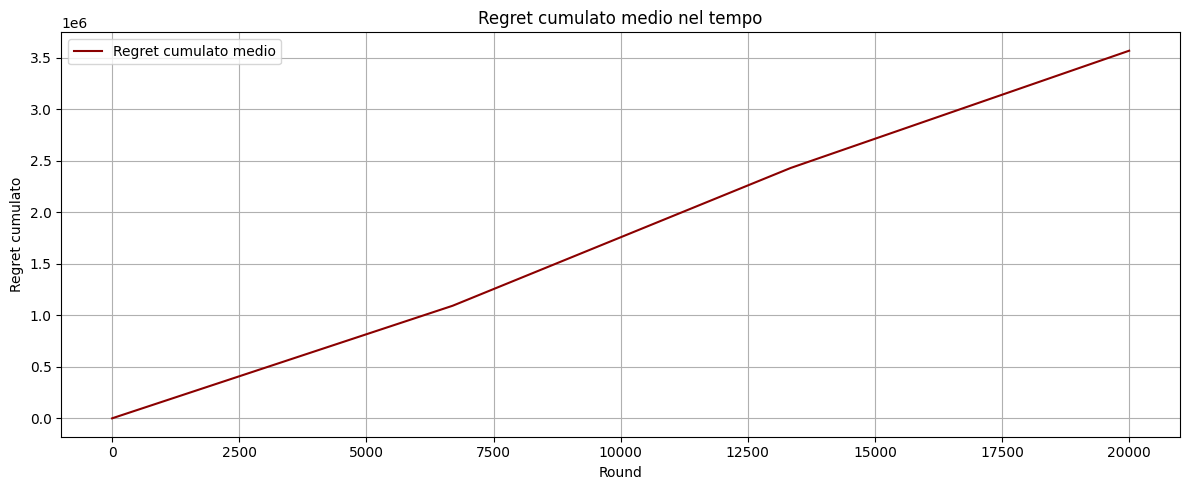

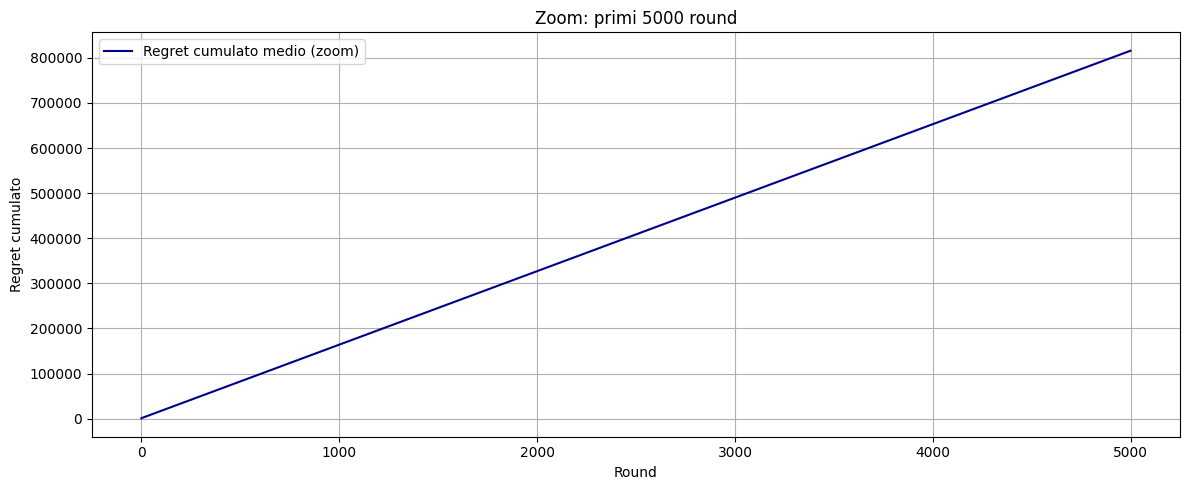

In [47]:
import matplotlib.pyplot as plt

# --- Plot  ---
plt.figure(figsize=(12, 5))
plt.plot(avg_regret, label='Regret cumulato medio', color='darkred')
plt.xlabel("Round")
plt.ylabel("Regret cumulato")
plt.title("Regret cumulato medio nel tempo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Zoom on 5000 rounds ---
plt.figure(figsize=(12, 5))
plt.plot(avg_regret[:zoom_end_5], label='Regret cumulato medio (zoom)', color='darkblue')
plt.xlabel("Round")
plt.ylabel("Regret cumulato")
plt.title(f"Zoom: primi {zoom_end_5} round")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [48]:
#Compute global average mean for each product
global_means = np.mean(mean_valuation_schedule, axis=0)

#Compute optimal static reward for each product 
static_best_prices = []
static_best_rewards = []
for i in range(N):
    p_star, r_star = compute_best_price(P, cost_vector[i], global_means[i], std_valuations[i], buyers_per_round)
    static_best_prices.append(p_star)
    static_best_rewards.append(r_star)

# Get oprimal reward for each rund
reward_star_static = np.sum(static_best_rewards) * np.ones(T)


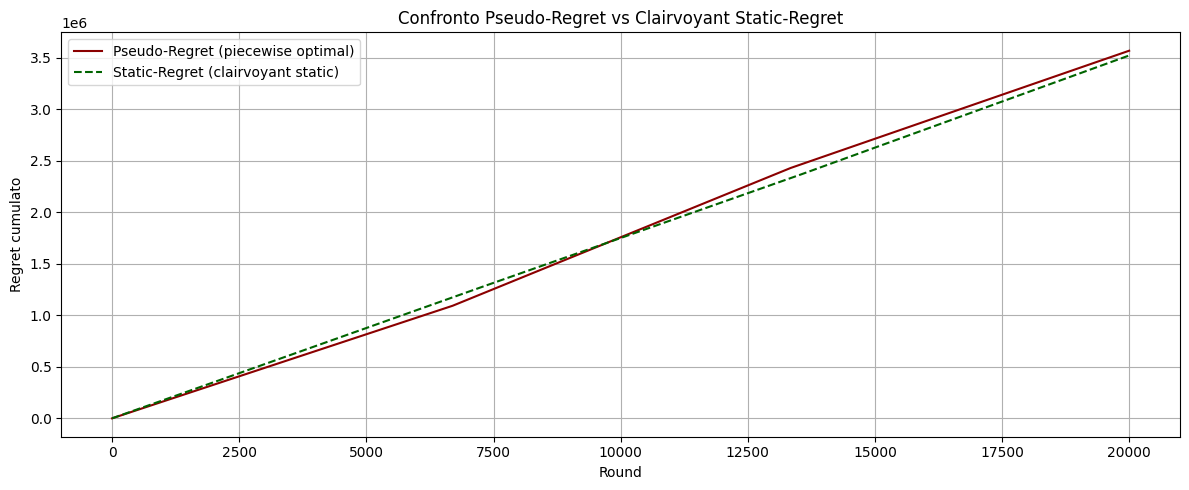

In [49]:
# Pseudo-regret (contro piecewise ottimo)
avg_regret_pseudo = np.mean([np.cumsum(reward_star - r) for r in rewards_trials], axis=0)

# Static-regret (contro clairvoyant statico)
avg_regret_static = np.mean([np.cumsum(reward_star_static - r) for r in rewards_trials], axis=0)

# --- Plot ---
plt.figure(figsize=(12, 5))
plt.plot(avg_regret_pseudo, label='Pseudo-Regret (piecewise optimal)', color='darkred')
plt.plot(avg_regret_static, label='Static-Regret (clairvoyant static)', color='darkgreen', linestyle='--')
plt.xlabel("Round")
plt.ylabel("Regret cumulato")
plt.title("Confronto Pseudo-Regret vs Clairvoyant Static-Regret")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
